# Setup

In [41]:
# I just prefer to load all necessary packages in one cell at the top of the file.

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
from math import *
from decimal import Decimal
import seaborn as sns
from datetime import datetime
# from ucimlrepo import fetch_ucirepo  # Not used; just a reference [See code cell 20].

# I ONLY USE SCIPY AND SKLEARN FOR CHECKING/COMPARING THE FUNCTIONALITY OF SOME OF THEIR FUNCTIONS AGAINST MY OWN.
import scipy as sp
from scipy.spatial.distance import minkowski
import sklearn as skl
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [42]:
# The prediction methods for my KNN takes long to run, I experimented with the below packages in an attempt to accelerate processing.

import tensorflow as tf
#import ctypes
#hllDll = ctypes.WinDLL("C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.4\\bin\\cudart64_12.dll")
print(tf.config.get_visible_devices())
print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
0
0


* Implementing multithreading would involve re-writing functions I want to use it for and could mix up indices if I'm not careful. Also, some packages' multithreading may not work with other packages.
* GPU acceleration cannot be implemented currently due to disagreement between the latest versions of Tensorflow and NVIDIA CUDA (missing or incorrectly mapped .dll files).
* Utilizing RDDs would severely limit the operations I can perform on data.


# Part A: Model Code (60 pts)

1. Write a function to calculate and return the Minkowski distance with optional argument p defaulting to ‘p=2’ (Euclidean) of two vectors where a vector represents a data point.[6 pts]

In [43]:
# Helper function - calculate distance value to given root value
# ('p' is root value)
# I'm going to name all of my custom functions starting with "custom_" so as not to
# confuse them with the SciPy versions of these functions later.

def p_root(value, root):
    root_value = 1 / float(root)
    return round(Decimal(value) **
                 Decimal(root_value), 3)


# Minkowski distance function using helper
def custom_minkowski_distance(x_vector, y_vector, p_value=2):
    # Parallel calculation of p_values
    return (p_root(sum(pow(abs(a - b), p_value)
                       for a, b in zip(x_vector, y_vector)), p_value))

In [44]:
# test execution with sample vectors
vector1 = np.array([0, 1, 2, 4])
vector2 = np.array([1, 3, 2, 5])
print("My function gives: ", custom_minkowski_distance(vector1, vector2))
print("Scipy minkowski function gives: ", minkowski(vector1, vector2))
del (vector1, vector2)

My function gives:  2.449
Scipy minkowski function gives:  2.449489742783178


2. Write a function to calculate and return the accuracy of two vectors. [4 pts]

In [45]:
def custom_accuracy(y_vals, y_preds):
    true_predictions = 0
    for i in range(len(y_vals)):
        if y_preds[i] == y_vals[i]:
            true_predictions += 1
    acc_val = true_predictions / len(y_vals)
    return round(acc_val, 3)

In [46]:
# test execution on sample data. Please note that I use normal lists at first because np.arrays sometimes cause errors with the SKLearn versions of these equations, and I want to be able to check the functionality of my functions against theirs at first for reality checking.
y_vals_input = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
y_preds_input = np.array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1])
#TP: 2
#FP: 2
#TN: 3
#FN: 3
print("My function accuracy score: ", custom_accuracy(y_vals_input, y_preds_input))
print("SKLearn accuracy score: ", skl.metrics.accuracy_score(y_vals_input, y_preds_input))

My function accuracy score:  0.5
SKLearn accuracy score:  0.5


3. Write three functions to compute: precision, recall and F1 score. [6 pts]

In [47]:
# For precision and recall, I simply tally up the True Positives, False Positives, True Negatives, and False Negatives where necessary and plug them in the appropriate equation.

# Although I have a chosen input order, F1 (and accuracy) should be the same regardless of which order you input the vectors into the equation. On the other hand, flipping the input vectors causes precision to actually return a recall value and vice-versa.

#Precision = TruePos / (TruePos + FalsePos)
def custom_precision(y_vals, y_preds):
    if len(y_preds.nonzero()[0]) == 0:
        raise Exception("Cannot calculate precision value: No predicted positives.")
    else:
        TruePos = 0
        FalsePos = 0
        for i in range(len(y_vals)):
            if y_preds[i] == 1:
                if y_vals[i] == 1: TruePos += 1
                if y_vals[i] == 0: FalsePos += 1
        prec_score = TruePos / len(y_preds.nonzero()[0])
    return round(prec_score, 3)


# Recall = TruePos / (TruePos + FalseNeg)
def custom_recall(y_vals, y_preds):
    TruePos = 0
    FalseNeg = 0
    for i in range(len(y_vals)):
        if y_vals[i] == 1:
            if y_preds[i] == 1: TruePos += 1
            if y_preds[i] == 0: FalseNeg += 1
    if len(y_preds.nonzero()[0]) == 0:
        raise Exception("Cannot calculate recall: No real positives.")
    else:
        recall_score = TruePos / (TruePos + FalseNeg)
    return round(recall_score, 3)


# F1 = TruePos / (TruePos + 0.5(FalsePos + FalseNeg)) ; HOWEVER,
# Here I use the equation for calculating F1 from precision and recall: F1 = (2 * Precision * Recall) / (Precision + Recall)
def custom_F1_score(y_vals, y_preds):
    precision_score = custom_precision(y_vals, y_preds)
    recall_score = custom_recall(y_vals, y_preds)
    F1_val = (2*(precision_score*recall_score))/(precision_score+recall_score)
    return round(F1_val, 3)

print("My func Precision score: ", custom_precision(y_vals_input, y_preds_input))
print("SKL Precision score: ", skl.metrics.precision_score(y_vals_input, y_preds_input))
print("My func Recall score: ", custom_recall(y_vals_input, y_preds_input))
print("SKL Recall score: ", skl.metrics.recall_score(y_vals_input, y_preds_input))
print("My func F1 score: ", custom_F1_score(y_vals_input, y_preds_input))
print("SKL F1 score: ", skl.metrics.f1_score(y_vals_input, y_preds_input))

My func Precision score:  0.5
SKL Precision score:  0.5
My func Recall score:  0.4
SKL Recall score:  0.4
My func F1 score:  0.444
SKL F1 score:  0.4444444444444445


4. Write a function to compute the confusion matrix of two vectors. [4 pts]

In [48]:
def custom_confusion_matrix(y_vals, y_preds):
    '''
    :param y_vals: A list or array of y-values
    :param y_preds: A list or array of y-value predictions
    :return: A dataframe confusion matrix
    '''
    TruePos = 0
    FalsePos = 0
    TrueNeg = 0
    FalseNeg = 0
    for i in range(len(y_vals)):
        if y_vals[i] == 1:
            if y_preds[i] == 1: TruePos += 1
            if y_preds[i] == 0: FalseNeg += 1
        else:
            if y_preds[i] == 1: FalsePos += 1
            if y_preds[i] == 0: TrueNeg += 1
    conf_mtrx = pd.DataFrame([[TruePos, FalsePos], [TrueNeg, FalseNeg]],
                             index=["Predicted Positive", "Predicted Negative"],
                             columns=["Actual Positive", "Actual Negative"])
    return conf_mtrx

print("My confusion matrix: \n", custom_confusion_matrix(y_vals_input, y_preds_input))
# With test vectors, should be:
# TP: 2 ; FP: 2
# TN: 3 ; FN: 3

#Compare to SKL function:
print("\nSKLearn confusion matrix:")
skl.metrics.confusion_matrix(y_vals_input, y_preds_input)

#Outputs match

My confusion matrix: 
                     Actual Positive  Actual Negative
Predicted Positive                2                2
Predicted Negative                3                3

SKLearn confusion matrix:


array([[3, 2],
       [3, 2]], dtype=int64)

5. Write a function to generate the Receiver Operating Characteristic (ROC) curve. [5 pts]

In [49]:
# First I build a function which takes a list of true y-values and a list of y-probabilities and gives roc 'coordinates'.
def custom_roc_calc(y_vals, y_probs):
    """ takes a list of true y-values and a list of y-probabilities and gives roc 'coordinates'.
    :param y_vals: list of y-values
    :param y_probs: list of probabilities that each y-value belongs to class 1.
    :return: an array of coordinates and an array of labels for ROC plotting.
    """
    # first check that the lengths of true values and probabilities match.
    if len(y_vals) != len(y_probs):
        raise Exception("Length of y_vals and y_probs do not match.")
    else:
        # Outermost loop loops over every unique y_prob value -- if this is too intensive for large datasets, I could change it to an arbitrary list of values from 0 to 1. I create one object which will contain the ROC 'coordinates', or True Positive Rate and False Positive Rate, and another object, which will contain labels indicating the threshold value at a given point.
        coords = [[], []]
        labels = []
        for i in range(len(np.unique(y_probs))):
            threshold = np.unique(y_probs)[i]
            labels.append(threshold)
            y_preds = []
            # This loop checks each probability value against the current threshold to produce predictions.
            for j in range(len(y_probs)):
                if y_probs[j] >= threshold:
                    y_preds.append(1)
                else:
                    y_preds.append(0)
            # This next loop calculates the number of True Positives and False Positives.
            TruePos = 0
            FalsePos = 0
            for k in range(len(y_preds)):
                if y_vals[k] == 1:
                    if y_preds[k] == 1: TruePos += 1
                if y_vals[k] == 0:
                    if y_preds[k] == 1: FalsePos += 1
            # I use the True Positive and False Positive counts to calculate the True Positive Rate and False Positive Rate. 
            # For simplicity, I call Counter(y_vals).get(1) for TP + FN and Counter(y_vals).get(0) for FP + TN rate.
            # I append these to the ROC coordinates object. This will produce an ROC coordinates object with as many coordinates as there are unique values of y_probs.
            TruePosRate = TruePos / y_vals.count(1)
            FalsePosRate = FalsePos / y_vals.count(0)
            coords[0].append(FalsePosRate)
            coords[1].append(TruePosRate)

        coords[0].append(0)
        coords[1].append(0)
        labels.append("")
        return coords, labels


# Next I produce a function to actually plot the graph from the values calculated in custom_roc_calc.

def custom_roc_curve(y_vals, y_probs):
    # I start with my helper function constructed above.
    roc_coords = custom_roc_calc(y_vals, y_probs)
    # I then produce a simple matplotlib plot
    roc_plot = plt.figure()
    plt.plot(roc_coords[0][0], roc_coords[0][1], figure=roc_plot)
    plt.title("ROC Plot", figure=roc_plot)
    plt.xlabel('False Positive Rate', figure=roc_plot)
    plt.ylabel('True Positive Rate', figure=roc_plot)
    plt.ylim((0, 1))
    plt.xlim((0, 1))
    # I include a Y=X axis line to represent the ROC of random guessing.
    plt.axline((0, 0), (1, 1), linestyle='--', alpha=0.5, color='gray', figure=roc_plot)
    # This loop plots the labels. Note: if I need, I may edit this or even disable it to limit the number of labels when plotting bigger datasets to avoid visual clutter. This is mostly intended for my own purposes optimizing my model later.
    labels = enumerate(roc_coords[1])
    for i, label in labels:
        plt.annotate(label, (roc_coords[0][0][i], roc_coords[0][1][i]))
    # By using plt.close() I set the plot to not display (until I call "return"). This way, this function will output the graph as an object without also printing it a second time.
    plt.close(roc_plot)
    return roc_plot


In [50]:
# I create & inspect test data and test my roc_calc function on it.
y_probs_input = [0.1, 0.01, 0.2, 0.45, 0.61, 0.2, 0.9, 0.1, 0.37, 0.9, 0.7, 0.8, 0.6, 0.3, 0.5, 0.55, 0.97, 0.88, 0.035,0.9]
y_vals_input = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
print("Probabilities and values are the same length: ", len(y_probs_input) == len(y_vals_input))
roc_coords_test = custom_roc_calc(y_vals_input, y_probs_input)
print("ROC coordinates: ", roc_coords_test[0])
print("ROC coordinate labels: ", roc_coords_test[1])

Probabilities and values are the same length:  True
ROC coordinates:  [[1.0, 0.9, 0.9, 0.7, 0.5, 0.5, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.0, 0], [1.0, 1.0, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.7, 0.6, 0.5, 0.5, 0.4, 0.3, 0.2, 0.1, 0]]
ROC coordinate labels:  [0.01, 0.035, 0.1, 0.2, 0.3, 0.37, 0.45, 0.5, 0.55, 0.6, 0.61, 0.7, 0.8, 0.88, 0.9, 0.97, '']


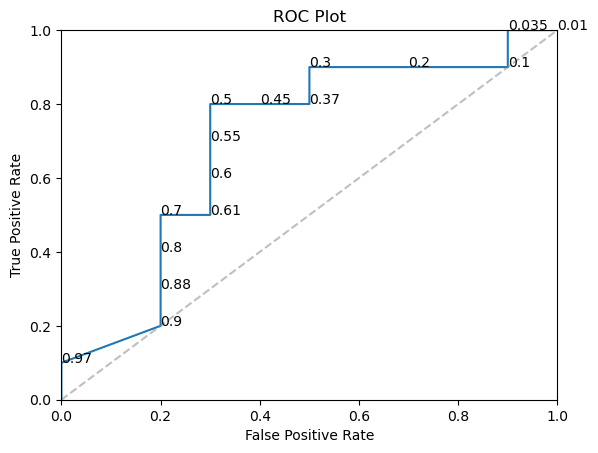

In [51]:
# Finally, I test my complete ROC plotting function on the test data.
ROC_graph = custom_roc_curve(y_vals_input, y_probs_input)
ROC_graph

6. Write a function to compute area under curve (AUC) for the ROC curve. [5 pts]


In [52]:
# When I think "area under curve" I think integral calculus--and ideally I would have wanted to approximate an equation for our ROC curve with perhaps a fourier analysis, and then integrate that equation from 0 to 1. However, since that would be prohibitively complicated in this context, I instead use simple geometry. I use the method listed in a number of sources (e.g. here: https://trumpexcel.com/calculate-area-under-curve-excel/). I divide the curve into trapezoids formed between the points, and calculate the sum total area of all those trapezoids.
def custom_auc_score(y_vals, y_preds):
    roc_coords = custom_roc_calc(y_vals, y_preds)
    area = 0
    # The equation for the area of a trapezoid is A = height * (length of top + length of bottom)/2
    # Using the abovementioned method of summing the areas of trapezoids formed between points, the area under the line between two points (x1, y1) and (x2, y2) can be computed: (y1 + y2)/2 * (x2 - x1) and the total area under the curve calculated as the sum of all those areas.
    for i in range((len(roc_coords[0][0]) - 1)):
        area += (roc_coords[0][1][i] + roc_coords[0][1][i + 1]) / 2 * (roc_coords[0][0][i] - roc_coords[0][0][i + 1])
    return area


In [53]:
print("My function AUC score:", custom_auc_score(y_vals_input, y_probs_input))
#Note that my method being a geometric approximation means it may not match 100% to the result found by an alternative method, but it is reliably close.

My function AUC score: 0.7


7. Write a function to generate the precision-recall curve. [5 pts]


In [218]:
def custom_precision_recall_calc(y_vals, y_probs):
    '''
    :param y_vals: a list of y-values.
    :param y_probs: a list of probabilities for each item in y_vals; probability that each given y-val belongs to class 1.
    :return: arrays of coordinates and labels for precision-recall plotting.
    '''
    # first check that the lengths of true values and probabilities match.
    if len(y_vals) != len(y_probs):
        raise Exception("Length of y_vals and y_probs do not match.")
    else:
        # Outermost loop loops over every unique y_prob value -- if this is too intensive for large datasets, I could change it to an arbitrary list of values from 0 to 1. I create one object which will contain the precision_recall 'coordinates', or precision and recall values, and another object, which will contain labels indicating the threshold value at a given point.
        coords = [[], []]
        labels = []
        for i in range(len(np.unique(y_probs))):
            threshold = np.unique(y_probs)[i]
            labels.append(threshold)
            y_preds = []
            # This loop checks each probability value against the current threshold to produce predictions.
            for j in range(len(y_probs)):
                if y_probs[j] >= threshold:
                    y_preds.append(1)
                else:
                    y_preds.append(0)
            # This next loop calculates the number of True Positives, False Positives, and False Negatives.
            TruePos = 0
            FalsePos = 0
            FalseNeg = 0
            for k in range(len(y_preds)):
                if y_vals[k] == 1:
                    if y_preds[k] == 1:
                        TruePos += 1
                    else:
                        FalseNeg += 1
                if y_vals[k] == 0:
                    if y_preds[k] == 1: FalsePos += 1
            # I use the TP, FP, and FN counts to calculate precision and recall and appends them to the P-R coordinates object. This will produce as many coordinates as there are unique values of y_probs.
            Precision = TruePos / (TruePos + FalsePos)
            Recall = TruePos / (TruePos + FalseNeg)
            coords[0].append(Precision)
            coords[1].append(Recall)
        coords[0].append(1)
        coords[1].append(0)
        labels.append("")
        return coords, labels


# Next I produce a function to actually plot the graph from the values calculated in custom_roc_calc.

def custom_precision_recall_curve(y_vals, y_probs):
    # I start with my helper function constructed above.
    pr_coords = custom_precision_recall_calc(y_vals, y_probs)
    # I then produce a simple matplotlib plot
    pr_plot = plt.figure()
    plt.plot(pr_coords[0][0], pr_coords[0][1], figure=pr_plot)
    plt.title("Precision-Recall Plot", figure=pr_plot)
    plt.xlabel('Recall', figure=pr_plot)
    plt.ylabel('Precision', figure=pr_plot)
    plt.ylim((0, 1))
    plt.xlim((0, 1))

    # This loop plots the labels. Note: if I need, I may edit this or even disable it to limit the number of labels when plotting bigger datasets to avoid visual clutter. This is mostly intended for my own purposes optimizing my model later.
    labels = enumerate(pr_coords[1])
    for i, label in labels:
        plt.annotate(label, (pr_coords[0][0][i], pr_coords[0][1][i]))

    # By using plt.close() I set the plot to not display (until I call "return"). This way, this function will output the graph as an object without also printing it a second time.
    plt.close(pr_plot)

    return pr_plot


In [219]:
pr_coords, pr_labels = custom_precision_recall_calc(y_vals_input, y_probs_input)
print("Precisions: ", pr_coords[0])
print("\nRecalls: ", pr_coords[1])
print("\nLabels (thresholds):", pr_labels)

Precisions:  [0.5, 0.5263157894736842, 0.5, 0.5625, 0.6428571428571429, 0.6153846153846154, 0.6666666666666666, 0.7272727272727273, 0.7, 0.6666666666666666, 0.625, 0.7142857142857143, 0.6666666666666666, 0.6, 0.5, 1.0, 1]

Recalls:  [1.0, 1.0, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.7, 0.6, 0.5, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

Labels (thresholds): [0.01, 0.035, 0.1, 0.2, 0.3, 0.37, 0.45, 0.5, 0.55, 0.6, 0.61, 0.7, 0.8, 0.88, 0.9, 0.97, '']


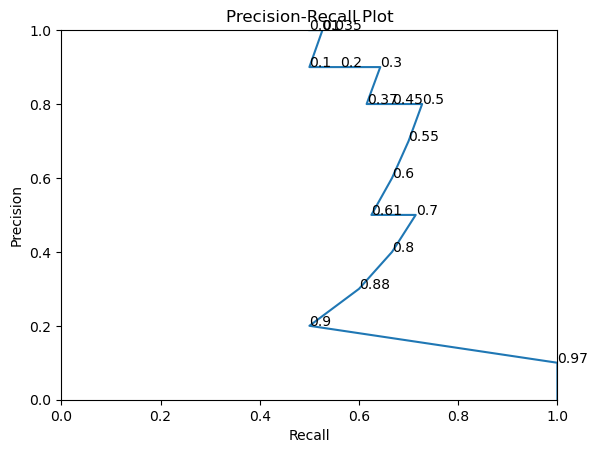

In [220]:
#I implement my final plotting function to generate the precision-recall graph for my sample data.
custom_precision_recall_curve(y_vals_input, y_probs_input)

8. Implement a KNN_Classifier model class. It should have the following three methods. [20
pts]
  a) __init__(self,) It’s a standard python initialization function so we can instantiate the
class. Just “pass” this. [5 pts]

Arguments:
- n_neighbors : int, optional (default = 5) The number of nearest neighbors.
- weights : string, optional (default = ‘uniform’) The weight function used in prediction.
Possible values:
- ‘uniform’: uniform weights. All points in each neighborhood are weighted
equally.
- ‘distance’: weight points by the inverse of their distance. in this case, closer
neighbors of a query point will have a greater influence than neighbors which are
further away
p: int, optional (default = 2) Minkowski distance.
Returns: No return value necessary.
b) fit(self, X, Y) This method simply needs to store the relevant values as instance
variables. [5 pts]
Arguments:
X : ndarray A numpy array with rows representing data samples and columns representing
features.
Y : ndarray A 1D numpy array with labels corresponding to each row of the feature matrix X.
Returns: No return value necessary.
c) predict(self, X,threshold=.5) This method will use the instance variables stored by the fit
method. [2 pts] Arguments:
X : ndarray A numpy array containing samples to be used for prediction. Its rows represent data
samples and columns represent features.
Returns: 1D array of class labels for each row in X. The 1D array should be designed as a
column vector. Hint: you can just have this call predict_proba(...) and use threshold after
d) predict_proba(self, X) Same as c) but for probabilities [3 pts] Arguments:
X : ndarray A numpy array containing samples to be used for prediction. Its rows represent data
samples and columns represent features.
Returns: 1D array of prediction probabilities for positive class for each row in X. The 1D
array should be designed as a column vector.
e) get_params(self) Get parameters for this estimator. [3 pts]
Arguments: N/A
Returns: dict Model parameter names mapped to their values.
f) set_params(self, **params) [2 pts] Arguments:
**params : dict A dictionary with the model parameter names to change mapped to their values
Returns: No return value necessary.

In [57]:
class KNN_Classifier:
    """
    A class to represent K-Nearest Neighbors.
    
    Parameters
    ----------
    n_neighbors : int, optional
        The number of nearest neighbors. (default is 5)
    weights : str, optional
        The weight function used in prediction. (Default is "uniform") Must be one of:
            - "uniform" : uniform weights. All points in each neighborhood are weighted equally.
            - "distance" : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    p : float, optional
        Minkowski distance p. (default is 2)
    """
    # Set weights types
    WEIGHTS_TYPE = [
        'uniform',
        'distance',
    ]

    # standard python initialization function so we can instantiate the class
    def __init__(self, n_neighbors: int = 5, weights: str = "uniform", p: int = 2):
        if weights not in KNN_Classifier.WEIGHTS_TYPE:
            raise ValueError("Invalid weights. Expected one of: %s" % KNN_Classifier.WEIGHTS_TYPE)

        self.n_neighbors = n_neighbors
        self.weights = weights
        self.p = p

        self._X = None        
        self._Y = None

    def fit(self, X: np.ndarray, Y: np.ndarray):
        """
        This method simply stores the relevant values as instance variables.
    
        :param X: A numpy array with rows representing data samples and columns representing features.
        :param Y: A 1D numpy array with labels corresponding to each row of the feature matrix X.
        :return: self
        """ 
        self._X = X
        self._Y = Y
        return self
        
    def predict(self, X: np.ndarray, threshold = .5):
        """
        This method uses the instance variables stored by the `fit` method.
    
        :param X: A numpy array containing samples to be used for prediction. Its rows represent data samples and columns represent features
        :param threshold: optional 
        :return: 1D array of class labels for each row in X. The 1D array should be designed as a column vector.
        """
        # Instead of calling predict_proba first, I used this function for working out my methods from the ground up. These methods are mirrored in my predict_proba methods, so I could feasibly work backwards and simplify this by implementing predict_proba here instead.
        if self._X is None or self._Y is None:
            raise AttributeError("Must call `.fit` method first.")

        # TODO (double-check)
        # ref: https://medium.com/analytics-vidhya/implementing-k-nearest-neighbours-knn-without-using-scikit-learn-3905b4decc3c
        if self.weights == "uniform":
            final_output = []
            for sample_index in range(len(X)): #iterate over every item in X
                distance_array = []
                votes = []
                for j in range(len(self._X)): # iterate over every item in training data
                    distance = custom_minkowski_distance(self._X[j], X[sample_index], self.p)
                    distance_array.append([distance, j])
                distance_array.sort()
                distance_range = distance_array[0:self.n_neighbors]
                for _key, value in distance_range:
                    votes.append(self._Y[value])
                votes_yes = Counter(votes).get(1)
                # additional operation for handling when votes == 0. (Counter returns None).
                if votes_yes == None:
                    votes_yes = 0
                if (votes_yes/(len(votes))) >= threshold:
                    final_output.append([1])
                else: final_output.append([0])
            return np.array(final_output)
        # Next, the alternative method for distance-weighted KNN
        if self.weights == "distance":
            final_output = []
            for sample_index in range(len(X)): #iterate over every item in X
                distance_array = []
                for j in range(len(self._X)): # iterate over every item in training data
                    distance = custom_minkowski_distance(self._X[j], X[sample_index], self.p)
                    distance_array.append([distance, self._Y[j]])
                distance_array.sort()
                distance_range = distance_array[0:self.n_neighbors]
                freq_zero = 0
                freq_one = 0
                for dist in distance_range:
                    #This first if-then is for avoiding divide-by-zero problems. If a point exactly overlaps another (dist[0] == 0), we assume a frequency value of exactly 1 or 0 (depending on the class of the overlapping point).
                    if dist[0] == 0:
                        if dist[1] == 0:
                            freq_zero = 1
                            freq_one = 0
                        else:
                            freq_zero = 0
                            freq_one = 1
                    # This next if-then calculates distance-weighted frequencies when dist[0] != 0.
                    elif dist[1] == 0:
                        freq_zero += (1 / dist[0])
                    else: freq_one += (1 / dist[0])
                # In the below if-else, I allow a way for the 'threshold' value to still serve a function with a weighted KNN.
                # At a threshold of 0.5, the below is identical to: if freq_one > freq_zero: final_output.append(1)
                # But, picking a different 'threshold' is now possible for tuning your weighted KNN.
                if (freq_one/(freq_one+freq_zero)) > threshold: final_output.append([1])
                else: final_output.append([0])
            return np.array(final_output)

    def predict_proba(self, X: np.ndarray):
        """
        This method calculates predictions for probabilities.

        :param X: A numpy array containing samples to be used for prediction. Its rows represent data samples and columns represent features.
        :return: 1D array of prediction probabilities for positive class for each row in X. The 1D array should be designed as a column vector.
        """
        if self._X is None or self._Y is None:
            raise AttributeError("Must call `.fit` method first.")
        # The first method for uniform weighted KNN
        if self.weights == "uniform":
            final_output = []
            for sample_index in range(len(X)): #iterate over every sample in X
                distance_array = []
                votes = []
                for j in range(len(self._X)): # iterate over every sample in training data
                    distance = custom_minkowski_distance(self._X[j], X[sample_index], self.p)
                    distance_array.append([distance, j])
                distance_array.sort()
                distance_range = distance_array[0:self.n_neighbors]
                for _key, value in distance_range:
                    votes.append(self._Y[value])
                votes_yes = Counter(votes).get(1)
                # additional operation for handling when votes == 0. (Counter returns None).
                if votes_yes == None:
                    votes_yes = 0
                prob_val = (votes_yes/(len(votes)))
                final_output.append([prob_val])
            return np.array(final_output)
        # Next, the alternative method for distance-weighted KNN. In this case the 'probabilities' will be the proportional weighted frequencies.
        if self.weights == "distance":
            final_output = []
            for sample_index in range(len(X)): #iterate over every item in X
                distance_array = []
                for j in range(len(_X)): # iterate over every item in training data
                    distance = custom_minkowski_distance(self._X[j], X[sample_index], self.p)
                    distance_array.append([distance, self._Y[j]])
                distance_array.sort()
                distance_range = distance_array[0:self.n_neighbors]
                freq_zero = 0
                freq_one = 0
                for dist in distance_range:
                    #This first if-then is for avoiding divide-by-zero problems. If a point exactly overlaps another (dist[0] == 0), we assume a frequency value of exactly 1 or 0 (depending on the class of the overlapping point).
                    if dist[0] == 0:
                        if dist[1] == 0:
                            freq_zero = 1
                            freq_one = 0
                        else:
                            freq_zero = 0
                            freq_one = 1
                    # This next if-then calculates distance-weighted frequencies when dist[0] != 0.
                    elif dist[1] == 0:
                        freq_zero += (1 / dist[0])
                    else: freq_one += (1 / dist[0])
                # Instead of returning the weighted frequencies, I return the proportional weighted frequencies.
                prob_val = (freq_one/(freq_one+freq_zero))
                final_output.append([prob_val])
            return np.array(final_output)
    
    def get_params(self):
        """
        Get parameters for this estimator.
        :return dict: Model parameter names mapped to their values.
        """
        return {
            "n_neighbors": self.n_neighbors,
            "weights": self.weights,
            "p": self.p
        }
    
    def set_params(self, **params):
        """
        A setter for this estimator.
        :param params: A dictionary with the model parameter names to change mapped to their values.
        :return: Nothing
        """
        # Also checks if relevant params are of correct type and not None.
        if params.get("n_neighbors") is not None:
            if type(params.get("n_neighbors")) is not int:
                raise TypeError("n_neighbors must be an integer")
            self.n_neighbors = params["n_neighbors"]
        if params.get("weights") is not None:
            if type(params.get("weights")) is not str:
                raise TypeError("weights must be a string")
            if params.get("weights") not in KNN_Classifier.WEIGHTS_TYPE:
                raise ValueError("Invalid weights. Expected one of: %s" % KNN_Classifier.WEIGHTS_TYPE)
            self.weights = params["weights"]
        if params.get("p") is not None:
            if type(params.get("p")) is not int:
                raise TypeError("p must be an integer")
            self.p = params["p"]

Below I use a few cells for testing my function on random data. I assign my own made-up points rather than using np.random because I wanted to test the effects of certain specific values and structures.

In [58]:
# Random data for testing
X = np.array([[0.2, 1.2],[8, 3.5],[7, 2.3],[4, 1.5],[2.5, 5.6],[5.8, 9.8],[9, 1.1],[12, 1],[1.1, 1], [2, 2], [12.1,3.2]]) # sample testing data
_X = np.array([[0, 9.9],[0.23, 1.1],[7.5, 2.1],[8.04,3.2],[7,7.1],[1.1, 9.1],[4,6.27],[5,6.9],[1,8.5],[2,12]]) # sample x_train
_Y = np.array([0,0,0,0,1,1,1,1,0,1]) # sample training labels


In [59]:
knnc_test = KNN_Classifier(weights = "uniform", n_neighbors=3)

print(knnc_test.fit(_X, _Y))
# expected output: KNeighborsClassifier(...)
print(knnc_test.predict(X))
# expected output: [1, 0]
print(knnc_test.predict_proba(X))
# expected output: [0.666..., 0.333...]

[[0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[0.33333333]
 [0.33333333]
 [0.33333333]
 [0.        ]
 [0.66666667]
 [1.        ]
 [0.33333333]
 [0.33333333]
 [0.33333333]
 [0.33333333]
 [0.33333333]]


In [60]:
##### Another test #####
knnc_test = KNN_Classifier(weights = "distance", n_neighbors=5)
print(knnc_test.fit(_X, _Y))
# expected output: KNeighborsClassifier(...)
print(knnc_test.predict(X))
# expected output: [1, 0]
print(knnc_test.predict_proba(X))

[[0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[Decimal('0.02868701917453504881168338236')]
 [Decimal('0.1486675752164350537671402977')]
 [Decimal('0.1907295477747882926946613529')]
 [Decimal('0.3361668813465465997579662788')]
 [Decimal('0.8245697830748831565238355061')]
 [Decimal('1')]
 [Decimal('0.3077332523292341977211179797')]
 [Decimal('0.4380762813076085311480574555')]
 [Decimal('0.1767558998116675598875391933')]
 [Decimal('0.3129653787159521193933875945')]
 [Decimal('0.4639243321831634944568113533')]]


9. Write a function named “partition” to split your data into training and test sets. The function
should take 4 arguments: [ 5 pts]
• feature matrix (numpy array with rows representing data samples and columns
representing features.),
• target vector (numpy array with labels corresponding to each row of the feature
matrix),
• t where t is a real number to determine the size of partition. For example, if t is set to
0.2, then 80% of the data will be used for training and 20% for testing.
• shuffle (default=True) where shuffle is a boolean whether to shuffle the data prior to
partitioning. You will be required to use “shuffle=True” for this assignment
• This function should return two feature matrices for training and test data, and two
target vectors for training and test data (4 tuple).

In [61]:
def partition(feature_matrix: np.ndarray, target_vector: np.ndarray, t = 0.2, shuffle=True, seed = 1):
    """
    This method splits the data into training and test sets.
    :param feature_matrix: numpy array with rows representing data samples and columns representing features.
    :param target_vector: numpy array with labels corresponding to each row of the feature matrix
    :param t: A real number to determine the size of partition. For example, if t is set to 0.2, then 80% of the data will be used for training and 20% for testing.
    :param shuffle: A boolean whether to shuffle the data prior to partitioning.
    :param seed: an optional seed value for random shuffle.
    :return: This function should return two feature matrices for training and test data, and two target vectors for training and test data (4 tuple).
    """
    # Exception handling first
    if type(feature_matrix) != np.ndarray:
        raise TypeError("feature_matrix must be of type: numpy.ndarray")
    if type(target_vector) != np.ndarray:
        raise TypeError("target_vector must be a 1D numpy array")
    if t > 1 or t < 0:
        raise ValueError("t must be a value between 0 and 1.")

    #I assign to a new object so that np.random.shuffle doesn't shuffle the original feature matrix
    _feature_matrix_mod = np.array(feature_matrix)
    _target_vector_mod = np.array(target_vector)
    if shuffle == True:
        #I include an extra parameter for setting random seed.
        np.random.seed(seed)
        #I have to use the below method of zipping the feature matrix and target vector together so that they shuffle in the same order.
        temp = list(zip(_feature_matrix_mod, _target_vector_mod))
        np.random.shuffle(temp)
        temp1, temp2 = zip(*temp)
        _feature_matrix_mod, _target_vector_mod = np.array(temp1), np.array(temp2)
    # Calculate the exact index at which to create a split
    _nrow = int(round(len(_feature_matrix_mod)*(1-t),0))
    # feature_matrix and target_vector should both be the same length, so I use the same _nrow val for both
    # training data takes rows in feature_matrix up to index _nrow.
    X_train = _feature_matrix_mod[0:_nrow]
    X_train_labels = _target_vector_mod[0:_nrow]
    # test data should take the rest of the array from the split point _nrow to the end of the feature_matrix.
    X_test = _feature_matrix_mod[_nrow:len(_feature_matrix_mod)]
    X_test_labels = _target_vector_mod[_nrow:len(_feature_matrix_mod)]

    return X_train, X_train_labels, X_test, X_test_labels

In [62]:
# I test my function
partition(_X, _Y)

(array([[ 7.5 ,  2.1 ],
        [ 2.  , 12.  ],
        [ 4.  ,  6.27],
        [ 7.  ,  7.1 ],
        [ 0.  ,  9.9 ],
        [ 8.04,  3.2 ],
        [ 0.23,  1.1 ],
        [ 5.  ,  6.9 ]]),
 array([0, 1, 1, 1, 0, 0, 0, 1]),
 array([[1. , 8.5],
        [1.1, 9.1]]),
 array([0, 1]))

# Part B: Data Processing, Feature Selection, and Initial Estimation (40 pts)

10. Read in the winequality-white.csv file as a Pandas data frame.

In [352]:
# Installing UCI's repo package and loading data from there loads it as a bespoke kind of repository called: ucimlrepo. For simplicity sake, I instead load from their /online/ archive as an SSV.
winequaltiy_white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
                                sep = ";")

11. The target will be the “quality” column which represents the rating of wine and ranges from 3 to 8. You will need to convert it into a two-category variable consisting of “good” (quality > 5) & “bad” (quality <= 5). Your target vector should have 0s (representing “bad” quality wine) and 1s (representing “good” quality wine). [2 pts]

In [ ]:
# I create a new variable for "binary quality"
winequaltiy_white.insert(12, "quality_bin", "NA")
# I populate it based on the values in "quality"
for i in range(len(winequaltiy_white)):
    if 3 <= winequaltiy_white['quality'][i] <= 5:
        # for simplifying later analysis, I create a binary variable where good = 1 and bad = 0
        winequaltiy_white["quality_bin"][i] = 0
    else: winequaltiy_white["quality_bin"][i] = 1

12. Provide a table with univariate statistics of your data (mean, standard deviation, and
quartiles, min, max, missing count, number of unique values). [4 pts]

In [65]:
# I instantiate my DF with wine_quality column names as my row indices. I then insert columns for each metric.
univariate_stats = pd.DataFrame(index = (winequaltiy_white.columns))

# Means:
univariate_stats.insert(0, column = "Mean", value = winequaltiy_white.mean())

# standard deviation
univariate_stats.insert(1, column = "SD", value = np.std(winequaltiy_white))

# quartiles
univariate_stats.insert(2, column = "Q1", value = winequaltiy_white.quantile(q = 0.25))
univariate_stats.insert(3, column = "Q2", value = winequaltiy_white.quantile(q = 0.5))
univariate_stats.insert(4, column = "Q3", value = winequaltiy_white.quantile(q = 0.75))

# min
univariate_stats.insert(5, column = "Min", value = winequaltiy_white.min())

# max
univariate_stats.insert(6, column = "Max", value = winequaltiy_white.max())

# missing count
univariate_stats.insert(7, column = "Missing", value = winequaltiy_white.isna().sum())

# number of unique values
univariate_stats.insert(8, column = "Unique", value = winequaltiy_white.nunique())

# Output table
univariate_stats

,Mean,SD,Q1,Q2,Q3,Min,Max,Missing,Unique
fixed acidity,6.854788,0.843782,6.3,6.8,7.3,3.8,14.2,0,68
volatile acidity,0.278241,0.100784,0.21,0.26,0.32,0.08,1.1,0,125
citric acid,0.334192,0.121007,0.27,0.32,0.39,0.0,1.66,0,87
residual sugar,6.391415,5.07154,1.7,5.2,9.9,0.6,65.8,0,310
chlorides,0.045772,0.021846,0.036,0.043,0.05,0.009,0.346,0,160
free sulfur dioxide,35.308085,17.005401,23.0,34.0,46.0,2.0,289.0,0,132
total sulfur dioxide,138.360657,42.493726,108.0,134.0,167.0,9.0,440.0,0,251
density,0.994027,0.002991,0.991723,0.99374,0.9961,0.98711,1.03898,0,890
pH,3.188267,0.150985,3.09,3.18,3.28,2.72,3.82,0,103
sulphates,0.489847,0.114114,0.41,0.47,0.55,0.22,1.08,0,79


13. Generate pair plots using the seaborn package to help identify redundant features. For any
redundant features(?), report, drop, and explain your logic (w/ markdown). [4 pts]

C:\Users\rmcnei\AppData\Local\anaconda3\envs\Assignment1\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


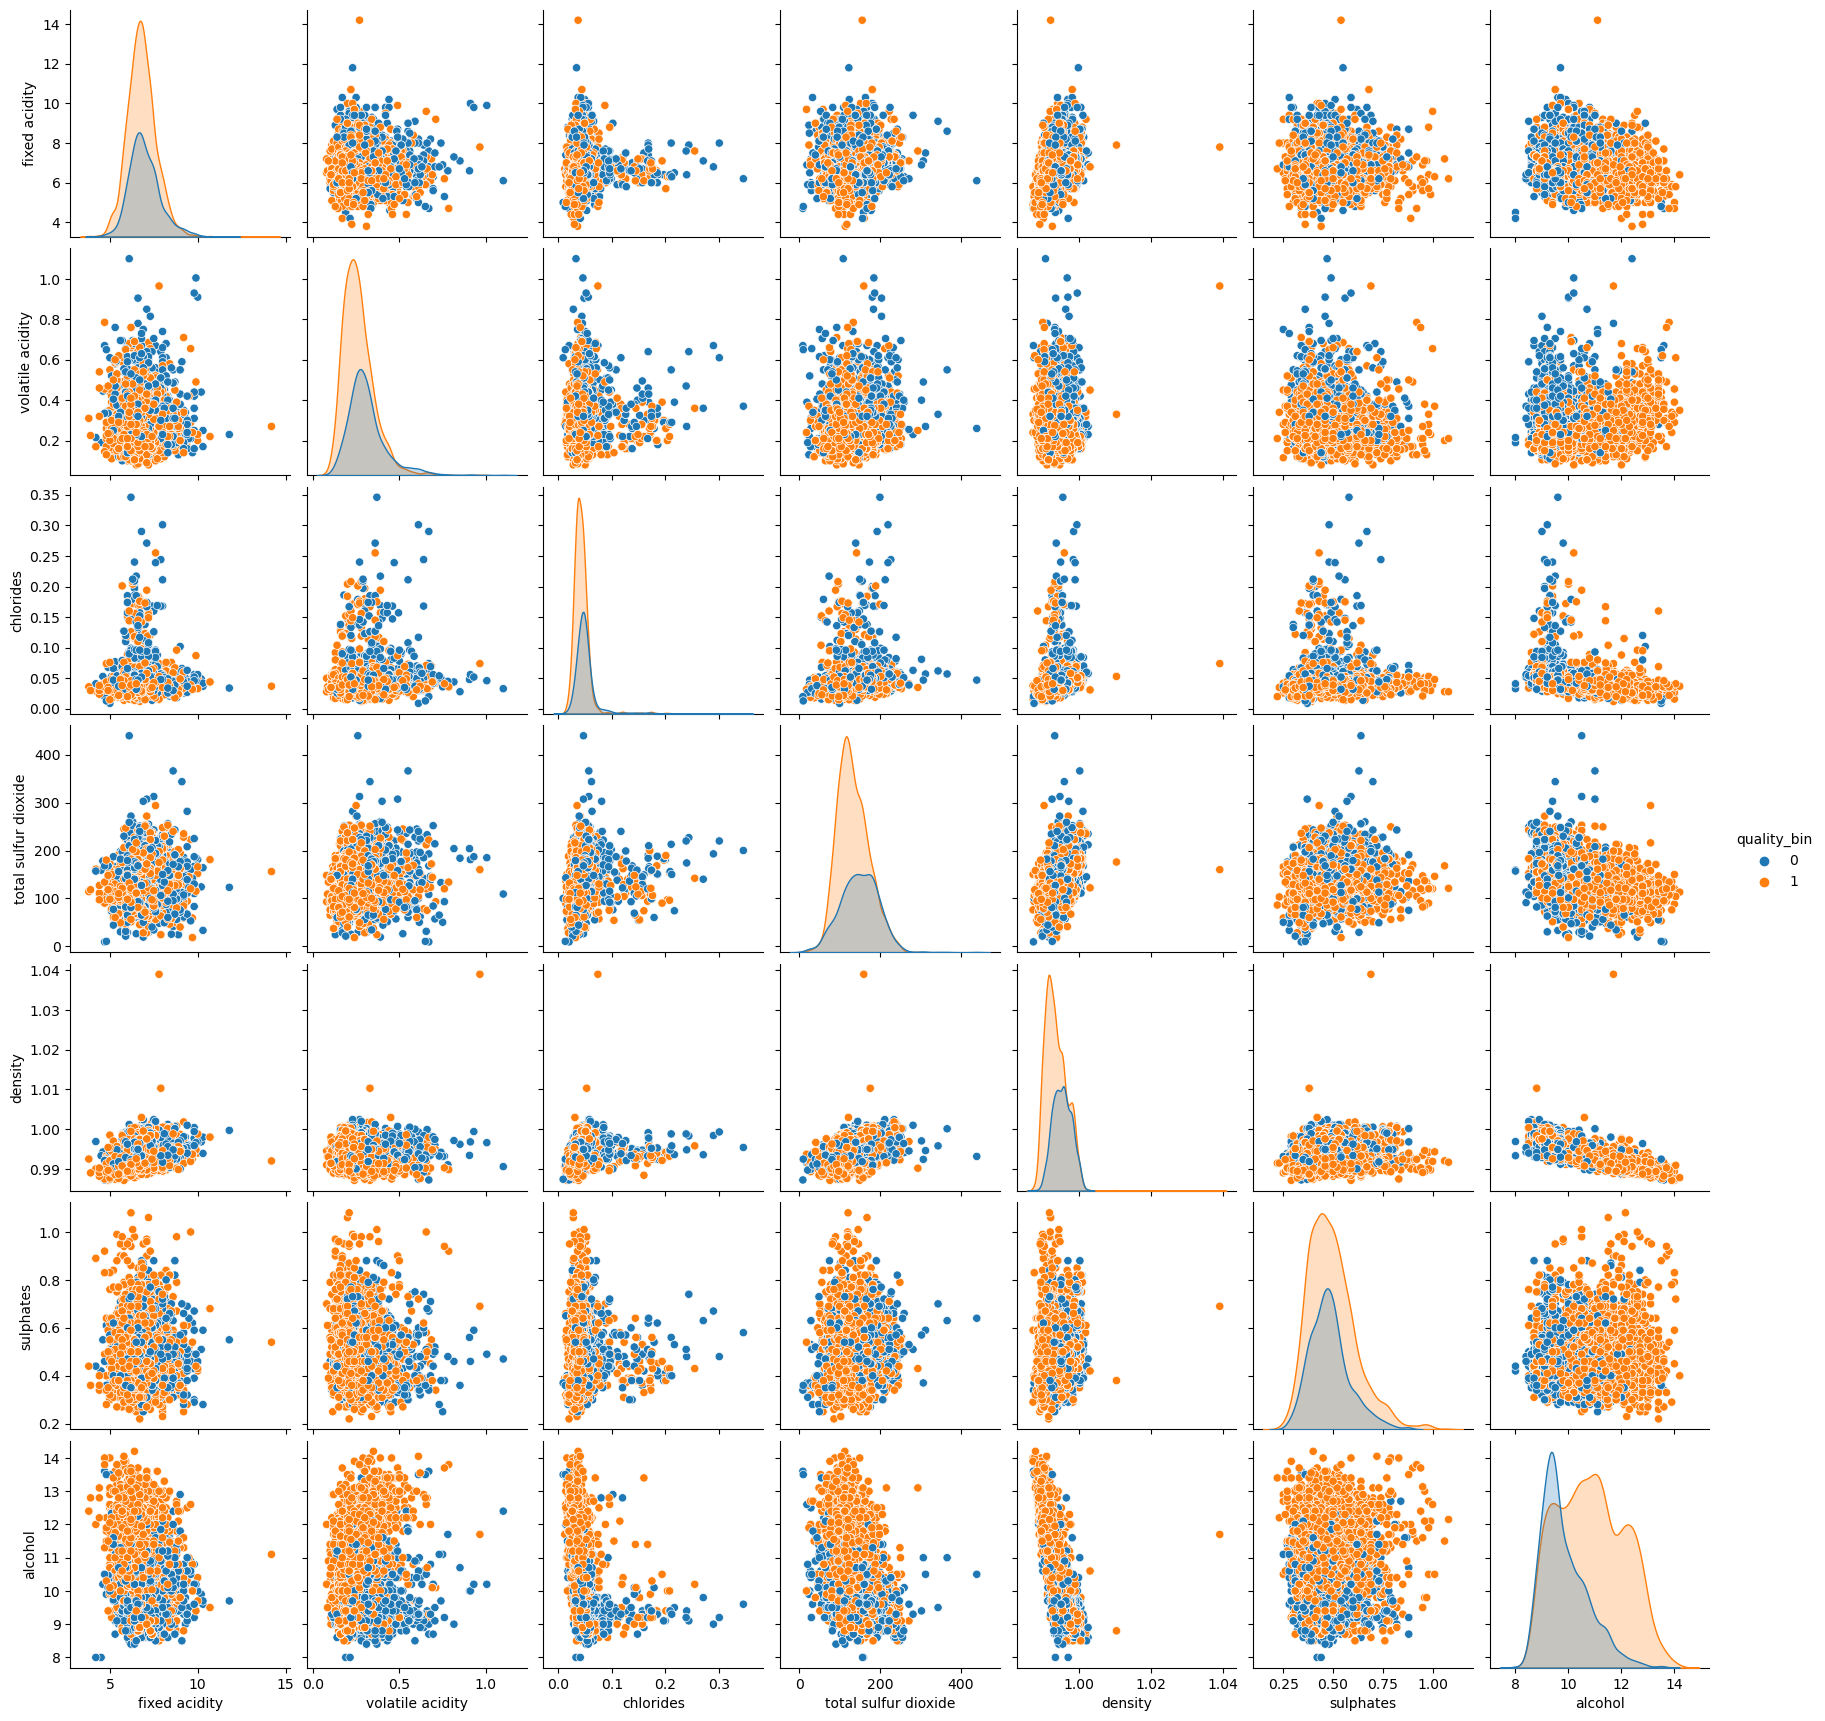

In [293]:
# I generate a pairplot with seaborn
sns.pairplot(winequaltiy_white, hue = "quality_bin")
plt.show()

None of the point clouds lead me to suspect that any particular pair of variables overlap more than any other. So, I'm primarily concerned with the diagonal plots and the 12th column.

At first, I don't see any especially obvious variables to remove. I initially suspect:

* Fixed acidity: The distributions for the quality groups seem to have similar means. Although, the point clouds with other variables seem to suggest this variable is fine for prediction. It isn't *more* multicolinear with other variables than any other variable.
* Citric Acid: The density curve suggests there are a few outliers in terms of citric acid content in the "good" group. This might contribute to noise and hinder predictive power.
* Alcohol: It seems like there is a lot of variation, especially in the "Good" group. On the other hand, there do seem to be distinct distributions in the alcohol content row, column 12 between the "good" and "bad" groups.
* Density & residual sugar: appear to be heavily colinear. And both these variables appear to have relatively flat distributions with regard to other variables.

In [66]:
# To assist my feature analysis, I test for correlation between variables. I proceed with simple independent-samples continuous-variable t-tests.

correlations_detected = 0
for i in range(len(winequaltiy_white.columns) - 1):
    for j in range(len(winequaltiy_white.columns) - 1):
        t_test = sp.stats.ttest_ind(np.array(winequaltiy_white[winequaltiy_white.columns[i]]),
                                    np.array(winequaltiy_white[winequaltiy_white.columns[j]]))
        if t_test.pvalue <= 0.05:
            if abs(t_test.statistic) > 1000:
                print("***")
            print("Significant correlation between {var1} and {var2}. corr: {corrval}, p-value: {pval}.".format(
                var1 = winequaltiy_white[winequaltiy_white.columns[i]].name,
                var2 = winequaltiy_white[winequaltiy_white.columns[j]].name,
                corrval = round(t_test.statistic, 4),
                pval = t_test.pvalue
            ))
            correlations_detected += 1

# ...unfortunately, I simply find that every single variable correlates significantly with every other variable.

print("Correlations detected: ", correlations_detected)
print("Maximum possible correlations: ", (((len(winequaltiy_white.columns) - 1)**2) - 12))

Significant correlation between fixed acidity and volatile acidity. corr: 541.5724, p-value: 0.0.
Significant correlation between fixed acidity and citric acid. corr: 535.3051, p-value: 0.0.
Significant correlation between fixed acidity and residual sugar. corr: 6.3071, p-value: 2.966798974236869e-10.
Significant correlation between fixed acidity and chlorides. corr: 564.5125, p-value: 0.0.
Significant correlation between fixed acidity and free sulfur dioxide. corr: -116.9437, p-value: 0.0.
Significant correlation between fixed acidity and total sulfur dioxide. corr: -216.5209, p-value: 0.0.
Significant correlation between fixed acidity and density. corr: 486.0556, p-value: 0.0.
Significant correlation between fixed acidity and pH. corr: 299.3264, p-value: 0.0.
Significant correlation between fixed acidity and sulphates. corr: 523.1104, p-value: 0.0.
Significant correlation between fixed acidity and alcohol. corr: -171.638, p-value: 0.0.
Significant correlation between fixed acidity an

Unfortunately, every variable appears to correlate significantly with every other variable. If I wanted to get even more granular, I could compare these results to Kruskwal-Wallis tests on the same variables (the non-parametric alternative to a t-test). What I did instead was rerun the above with an additional loop to print a line of "***" to highlight any variables that correlate with an absolute corr value > 1000.

* I identify pH as a particularly strong autocorrelation variable (see the number of pH corr values > 1000 in the above output).

In [67]:
# Third, I perform a point biserial correlation test on each variable against binary quality.

correlations_detected = 0
for i in range(len(winequaltiy_white.columns) - 1):
    # perform pbc test on each column in winequality
    pbc = sp.stats.pointbiserialr(winequaltiy_white[winequaltiy_white.columns[i]], winequaltiy_white[winequaltiy_white.columns[12]])
    if pbc.pvalue <= 0.05:
        print("Significant correlation between Binary Quality and {var2}. corr: {corrval}, p-value: {pval}.".format(
            var2 = winequaltiy_white[winequaltiy_white.columns[i]].name,
            corrval = round(pbc.correlation, 4),
            pval = pbc.pvalue
        ))
        correlations_detected += 1
    else: print("***\nNO significant correlation between Binary Quality and {var2}. corr: {corrval}, p-value: {pval}.".format(
        var2 = winequaltiy_white[winequaltiy_white.columns[i]].name,
        corrval = round(pbc.correlation, 4),
        pval = pbc.pvalue
    ))

print("Correlations detected: ", correlations_detected)
print("Maximum possible correlations: ", len(winequaltiy_white.columns) - 1)

Significant correlation between Binary Quality and fixed acidity. corr: -0.0897, p-value: 3.128964348944922e-10.
Significant correlation between Binary Quality and volatile acidity. corr: -0.2254, p-value: 1.7704166811180115e-57.
***
NO significant correlation between Binary Quality and citric acid. corr: -0.0007, p-value: 0.9609110640524073.
Significant correlation between Binary Quality and residual sugar. corr: -0.0928, p-value: 7.821664185151443e-11.
Significant correlation between Binary Quality and chlorides. corr: -0.1839, p-value: 1.5740357233481027e-38.
***
NO significant correlation between Binary Quality and free sulfur dioxide. corr: -0.0013, p-value: 0.9287423255594872.
Significant correlation between Binary Quality and total sulfur dioxide. corr: -0.1709, p-value: 1.9884513596277714e-33.
Significant correlation between Binary Quality and density. corr: -0.2687, p-value: 9.077527335422904e-82.
Significant correlation between Binary Quality and pH. corr: 0.0837, p-value: 4.

By the above test, I identify "Citric Acid" and "Free Sulfur Dioxide" as having *No Significant correlation* with "Binary Quality".
Also note that "Sulfates" correlates with a relatively higher p-value (less certain significance) than other significant variables.

To be cut, we now have:
* Citric Acid: Does not correlate with binary quality.
* Free Sulfur Dioxide: Does not correlate with binary quality.
* Residual Sugar: In the pairplots, density and residual sugar appear to be colinear.
    * Residual Sugar x Binary Quality: corr = -0.0928, p-val << 0.01
    * Density x Binary Quality: corr = -0.2687, p-val << 0.01
    * Since Density has a slightly stronger correlation (abs(corr)) with Binary Quality, I'll keep Density and drop Residual sugar.
* pH: Especially strongly correlated with multiple other predictor variables. Doesn't *have* to be dropped, but I opt to do so.
* Quality: Given that quality_bin was generated from quality, this variable is redundant.

In [68]:
# I drop the chosen columns
winequaltiy_white = winequaltiy_white.drop(["citric acid",
                                            "free sulfur dioxide",
                                            "residual sugar",
                                            "pH",
                                            "quality"],
                                         axis=1)
winequaltiy_white

,fixed acidity,volatile acidity,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality_bin
0,7.0,0.27,0.045,170.0,1.00100,0.45,8.8,1
1,6.3,0.30,0.049,132.0,0.99400,0.49,9.5,1
2,8.1,0.28,0.050,97.0,0.99510,0.44,10.1,1
3,7.2,0.23,0.058,186.0,0.99560,0.40,9.9,1
4,7.2,0.23,0.058,186.0,0.99560,0.40,9.9,1
...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.039,92.0,0.99114,0.50,11.2,1
4894,6.6,0.32,0.047,168.0,0.99490,0.46,9.6,0
4895,6.5,0.24,0.041,111.0,0.99254,0.46,9.4,1
4896,5.5,0.29,0.022,110.0,0.98869,0.38,12.8,1


14. Use your “partition” function to split the data into 80% train and 20% test. [5 pts]

In [69]:
# I start by converting the appropriate
wine_feature_matrix = np.array(winequaltiy_white.iloc[:,0:6])
wine_target_vector = np.array(winequaltiy_white.iloc[:,7])

In [70]:
X_train, y_train, X_test, y_test = partition(wine_feature_matrix, wine_target_vector)

15. Naively run your KNN_Classifier model on the training dataset with n_neighbors = 5 and
using Euclidean distance. [15 pts]

In [32]:
# Since Minkowski generalizes to Euclidean distance when p = 2. I simply run my KNN with the default parameters (including p = 2)
knnc = KNN_Classifier()
knnc.fit(X_train, y_train)
# This takes about 10 min to execute
start = datetime.now()
predictions1 = knnc.predict(X_test)
finish = datetime.now()
KNN_time_elapsed = (finish - start)
print("Time elapsed during KNN prediction: ", KNN_time_elapsed)

Time elapsed during KNN prediction:  0:09:44.818207


In [33]:
predictions1[0:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1]])

a. Use accuracy and F1 score to compare your predictions to the expected labels.

In [34]:
print("Model accuracy: ", custom_accuracy(y_test, predictions1))
print("Model F1 score: ", custom_F1_score(y_test, predictions1))

Model accuracy:  0.693
Model F1 score:  0.782


b. Now standardize each feature of your training set (subtract mean and divide by
standard deviation) and apply trained standardization to the test set. Use the mean
and standard deviation values for each feature in the training set to scale the test
data (you can use sklearn.preprocessing.StandardScaler)

In [71]:
scaler = skl.preprocessing.StandardScaler()
scaler.fit(wine_feature_matrix)
scaled_X = scaler.transform(wine_feature_matrix)
scaled_X[0:10]

array([[ 1.72096961e-01, -8.17699008e-02, -3.53550004e-02,
         7.44565035e-01,  2.33151201e+00, -3.49184257e-01],
       [-6.57501128e-01,  2.15895632e-01,  1.47747079e-01,
        -1.49684624e-01, -9.15417164e-03,  1.34184656e-03],
       [ 1.47575110e+00,  1.74519434e-02,  1.93522599e-01,
        -9.73335626e-01,  3.58664800e-01, -4.36815783e-01],
       [ 4.09124986e-01, -4.78657278e-01,  5.59726758e-01,
         1.12109121e+00,  5.25855242e-01, -7.87341887e-01],
       [ 4.09124986e-01, -4.78657278e-01,  5.59726758e-01,
         1.12109121e+00,  5.25855242e-01, -7.87341887e-01],
       [ 1.47575110e+00,  1.74519434e-02,  1.93522599e-01,
        -9.73335626e-01,  3.58664800e-01, -4.36815783e-01],
       [-7.76015140e-01,  4.14339320e-01, -3.53550004e-02,
        -5.55530812e-02,  2.91788624e-01, -1.73921205e-01],
       [ 1.72096961e-01, -8.17699008e-02, -3.53550004e-02,
         7.44565035e-01,  2.33151201e+00, -3.49184257e-01],
       [-6.57501128e-01,  2.15895632e-01,  1.477

c. Re-run the KNN_Classifier model on the standardized data, find the accuracy and F1
score with the expected labels.

In [36]:
# I re-partition (if I had scaled X_train and X_test separately, I wouldn't get the same results).
X_train, y_train, X_test, y_test = partition(scaled_X, wine_target_vector)
# I then run this new scaled data through my KNN.
knnc.fit(X_train, y_train)
# This takes about 10 min to execute
start = datetime.now()
predictions2 = knnc.predict(X_test)
finish = datetime.now()
KNN_time_elapsed = (finish - start)
print("Time elapsed during KNN prediction: ", KNN_time_elapsed)

Time elapsed during KNN prediction:  0:10:44.715094


In [37]:
predictions2[0:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1]])

In [38]:
print("Model accuracy: ", custom_accuracy(y_test, predictions2))
print("Model F1 score: ", custom_F1_score(y_test, predictions2))

Model accuracy:  0.736
Model F1 score:  0.805


d. Compare the two accuracy values and the F1 scores; and decide whether you should
use standardized data or unscaled data for the remainder of the assignment.

In [39]:
print("Unscaled data model accuracy: ", custom_accuracy(y_test, predictions1))
print("Scaled data model accuracy: ", custom_accuracy(y_test, predictions2))
print("Unscaled data model F1 score: ", custom_F1_score(y_test, predictions1))
print("Scaled data model F1 score: ", custom_F1_score(y_test, predictions2))

Unscaled data model accuracy:  0.693
Scaled data model accuracy:  0.736
Unscaled data model F1 score:  0.782
Scaled data model F1 score:  0.805


e. Perform a similar test for inverse distance weighting in the KNN_Classifier model
and determine whether or not to use it. [5 pts]

In [40]:
# Distance-weighted KNN on unscaled data:
X_train, y_train, X_test, y_test = partition(wine_feature_matrix, wine_target_vector)
knnc2 = KNN_Classifier(weights="distance")
knnc2.fit(X_train, y_train)
start = datetime.now()
predictions3 = knnc2.predict(X_test)
finish = datetime.now()
KNN_time_elapsed = (finish - start)
print("Time elapsed during distance-weighted KNN prediction: ", KNN_time_elapsed)

Time elapsed during distance-weighted KNN prediction:  0:09:45.681219


In [41]:
predictions3[0:10]

array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1]])

In [42]:
# Distance-weighted KNN on scaled data:
X_train, y_train, X_test, y_test = partition(scaled_X, wine_target_vector)
knnc2.fit(X_train, y_train)
start = datetime.now()
predictions4 = knnc2.predict(X_test)
finish = datetime.now()
KNN_time_elapsed = (finish - start)
print("Time elapsed during distance-weighted KNN prediction: ", KNN_time_elapsed)

Time elapsed during distance-weighted KNN prediction:  0:10:44.624672


In [43]:
predictions4[0:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1]])

In [48]:
# Comparison
print("ACCURACIES")
print("Unscaled uniform-weighted data model accuracy: ", custom_accuracy(y_test, predictions1))
print("Scaled uniform-weighted data model accuracy: ", custom_accuracy(y_test, predictions2))
print("Unscaled data distance-weighted model accuracy: ", custom_accuracy(y_test, predictions3))
print("Scaled data distance-weighted model accuracy: ", custom_accuracy(y_test, predictions4))
print("\nF1 SCORES")
print("Unscaled uniform-weighted data model F1 score: ", custom_F1_score(y_test, predictions1))
print("Scaled uniform-weighted data model F1 score: ", custom_F1_score(y_test, predictions2))
print("Unscaled data distance-weighted model F1 score: ", custom_F1_score(y_test, predictions3))
print("Scaled data distance-weighted model F1 score: ", custom_F1_score(y_test, predictions4))

ACCURACIES
Unscaled uniform-weighted data model accuracy:  0.693
Scaled uniform-weighted data model accuracy:  0.736
Unscaled data distance-weighted model accuracy:  0.655
Scaled data distance-weighted model accuracy:  0.719

F1 SCORES
Unscaled uniform-weighted data model F1 score:  0.782
Scaled uniform-weighted data model F1 score:  0.805
Unscaled data distance-weighted model F1 score:  0.75
Scaled data distance-weighted model F1 score:  0.791


The uniform-weighted model using scaled data achieves the best performance of any model, having both the highest accuracy and highest F1 score.
* Each model using scaled data outperforms its counterpart using unscaled data.
* Each uniform-weighted model outperforms its distance-weighted counterpart.

In [45]:
# I save my predictions so I don't have to re-run the above (~50 min) every time I re-open my IDE.
np.save("predictions1", predictions1)
np.save("predictions2", predictions2)
np.save("predictions3", predictions3)
np.save("predictions4", predictions4)

In [72]:
predictions1 = np.load("predictions1.npy")
predictions2 = np.load("predictions2.npy")
predictions3 = np.load("predictions3.npy")
predictions4 = np.load("predictions4.npy")

16. Repeat #15 a-d, but using a logistic regression with ‘elasticnet’ or ‘l2’ penalty (feel free to
use sklearn.linear_model.LogisticRegression) [10 pts]

In [73]:
# Logreg on unscaled data with elasticnet penalty
# Split
X_train, y_train, X_test, y_test = partition(wine_feature_matrix, wine_target_vector)
# Logreg with elasticnet. I need to raise max iter to 10000 to get convergence.
logreg1 = skl.linear_model.LogisticRegression(solver="saga",
                                              penalty= "elasticnet",
                                              l1_ratio=0.5,
                                              max_iter=10000)
logreg1.fit(X_train, y_train)
logreg1Preds1 = logreg1.predict(X_test)

In [74]:
#Logreg on unscaled data with l2 pentalty
logreg2 = skl.linear_model.LogisticRegression(penalty = "l2",
                                              max_iter = 1000)
logreg2.fit(X_train, y_train)
logreg2preds1 = logreg2.predict(X_test)

In [75]:
#Logreg on scaled data with elasticnet penalty
X_train, y_train, X_test, y_test = partition(scaled_X, wine_target_vector)
logreg1.fit(X_train, y_train)
logreg1preds2 = logreg1.predict(X_test)

In [76]:
#Logreg on scaled data with l2 penalty
logreg2.fit(X_train, y_train)
logreg2preds2 = logreg2.predict(X_test)

In [77]:
#Compare performance among LogRegs
print("ACCURACIES")
print("LogReg ElasticNet unscaled accuracy: ", custom_accuracy(y_test, logreg1Preds1))
print("LogReg L2 unscaled accuracy: ", custom_accuracy(y_test, logreg2preds1))
print("LogReg ElasticNet scaled accuracy: ", custom_accuracy(y_test, logreg1preds2))
print("LogReg L2 scaled accuracy: ", custom_accuracy(y_test, logreg2preds2))
print("F1 SCORES")
print("LogReg ElasticNet unscaled F1: ", custom_F1_score(y_test, logreg1Preds1))
print("LogReg L2 unscaled F1: ", custom_F1_score(y_test, logreg2preds1))
print("LogReg ElasticNet scaled F1: ", custom_F1_score(y_test, logreg1preds2))
print("LogReg L2 scaled F1: ", custom_F1_score(y_test, logreg2preds2))

ACCURACIES
LogReg ElasticNet unscaled accuracy:  0.666
LogReg L2 unscaled accuracy:  0.673
LogReg ElasticNet scaled accuracy:  0.698
LogReg L2 scaled accuracy:  0.698
F1 SCORES
LogReg ElasticNet unscaled F1:  0.793
LogReg L2 unscaled F1:  0.79
LogReg ElasticNet scaled F1:  0.796
LogReg L2 scaled F1:  0.796


Scaling the data improves performance. L2 penalty slightly outperforms ElasticNet for unscaled data, but makes no difference for scaled data. I doubled-back assuming I must have used the same regression twice for ElasticNet Scaled & L2 Scaled, but these are in fact the performance of two different models. Even at 10000 iterations, these run much more quickly than my custom KNN function. However, none of them achieve better performance than my best-performing KNN model, uniform-weighted KNN using scaled data (accuracy: 0.736; F1: 0.805).


# Part C: Model Evaluation and Results Summary (100pts)

17) Evaluation of an estimator performance via cross-validation: Implement the S-fold cross validation function. [15 pts]
    a. sFold(folds, data, labels, model, model_args, error_function)
        i. folds is an integer number of folds.
        ii. data is a numpy array with rows representing data samples and columns representing features.
        iii. labels is a numpy array with labels corresponding to each row of training_features.
        iv. model is an object with the fit and predict methods.
        v. model args is a dictionary of arguments to pass to the classification algorithm. If you are unfamiliar, look up using the ** operator to unpack dictionaries as arguments
        vi. error_function :Returns error value between predicted and true labels. For example, mean squared error (mse) function could be used as error_function.
    b. How it should work:
        i. Use a helper function to calculate an s-partition of the data (i.e., partition the data into s equally sized portions). You may use sklearn.model_selection.KFold if you wish and assume data is already shuffled.
        ii. For each partition
            a. Make a model using the model class
            b. Fit the data to all other partitions (1 – folds)
            c. Make prediction on current partition
            d. Store expected labels and predicted labels for current partition
        iii. Calculate the average error (for all partitions) using the error_function on stored expected and predicted labels
c. It should return a Python tuple with the following
    i. Expected labels
    ii. Predicted labels
    iii. Average error

In [78]:
def sFold(folds: int, data_sfold: np.ndarray, labels_sfold: np.ndarray, model: object, model_args: dict, error_function):
    """
     An S-fold cross-validation function.

    Parameters
    ----------
    folds : int,
        The number of folds.
    data_sfold : numpy array
        A numpy array with rows representing data samples and columns representing features.
    labels_sfold : numpy array
        An 1D array with labels corresponding to each row of training_features.
    model : model object
        Any object with the fit and predict methods
    model_args : dict
        dictionary of arguments to pass to the classification algorithm.
    error_function : any error function
        A function that returns error value between predicted and true labels. For example, mean squared error (mse) function could be used as error function.
    """
    # Initialize lists for labels
    expected_labels = []
    predicted_labels = []
    _errors = []

    # "Use a helper function to calculate an s-partition of the data (i.e., partition the data into s equally sized portions). You may use sklearn.model_selection.KFold if you wish and assume data is already shuffled."
    # Create KFold
    _kf = skl.model_selection.KFold(n_splits = folds)

    # "For each partition"
    # Loop for iterating over each fold
    for _train_index, _test_index in _kf.split(data_sfold):
        # "Make a model using the model class"
        _model_instance = model(**model_args)

        # Split data into training and testing sets
        _X_train, _X_test = data_sfold[_train_index], data_sfold[_test_index]
        _y_train, _y_test = labels_sfold[_train_index], labels_sfold[_test_index]

        # "Fit the data to all other partitions (1 – folds)"
        # Fit the model on the training data
        _model_instance.fit(_X_train, _y_train)

        # Predict labels for the test data
        # "Make prediction on current partition"
        _y_pred = _model_instance.predict(_X_test)

        # "Store expected labels and predicted labels for current partition"
        expected_labels.extend(_y_test)
        predicted_labels.extend(_y_pred)

        # Calculate error for this fold
        fold_error = error_function(_y_test, _y_pred)
        _errors.append(fold_error)

    # "Calculate the average error (for all partitions) using the error_function on stored expected and predicted labels"
    # Calculate average error across all folds
    average_error = np.mean(_errors)

    # "It should return a Python tuple with the following"
    # "i. Expected labels"
    # "ii. Predicted labels"
    # "iii. Average error"
    return np.array(expected_labels), np.array(predicted_labels), average_error


18) Only using the training portion of your data, use your sFold function to evaluate the performance of your model over each combination of k and distance metrics from the following sets: [10 pts]
    i. k=[1,5,9,11]
        b. distance = [Euclidean, Manhattan]
    ii. weights = [uniform, distance]
    iii. From the returned tuple store as a row in a pandas DataFrame with headers:
        Experiment name, k, distance, weights, Average F1
    iv. Determine the best model based on the overall performance. For the error_function of the S-fold function argument use the F1 score function from Part A.

In [79]:
# Overwrite train & test splits.
X_train, y_train, X_test, y_test = partition(scaled_X, wine_target_vector)
print(X_train)

[[-0.77601514  1.00967039  2.25342099  1.33288718  1.23808652  1.92923542]
 [-0.53898711 -0.28021359 -0.035355    1.66234758  0.52585524 -0.61207884]
 [-0.53898711 -0.28021359 -0.31000812  0.20330866 -0.64447785 -0.78734189]
 ...
 [ 0.17209696  0.11667379 -0.53888572 -0.26734905 -0.41041123 -0.43681578]
 [-0.77601514 -0.28021359 -0.035355    1.63881469  0.56598095 -0.26155273]
 [ 1.4757511  -0.0817699  -0.7219878  -0.83213831 -0.49400645  1.22818321]]


In [36]:
start = datetime.now()
# Only using the training portion of your data,
# use your sFold function to evaluate the performance of your model
# over each combination of k and distance metrics from the following sets
k=[1,5,9,11]
# Euclidean: p = 2
# Manhattan: p = 1
# distance = [Euclidean, Manhattan]
distance_p = [2, 1]
weights = ['uniform', 'distance']

sfold_evaluations = []
for k_val in k:
    for distance_p_val in distance_p:
        for weights_val in weights:
            model_args = {"n_neighbors": k_val, "weights": weights_val, "p": distance_p_val}
            # For the error_function of the S-fold function argument use the F1 score function from Part A.
            _, _, _average_f1_knnc = sFold(folds=5,
                                           data_sfold=X_train,
                                           labels_sfold=y_train,
                                           model=KNN_Classifier,
                                           model_args=model_args,
                                           error_function=custom_F1_score)
            sfold_evaluations.append({
                "average_f1_knnc": _average_f1_knnc,
                "model_args": model_args
            })

print(sfold_evaluations)

finish = datetime.now()
elapsed_time = finish - start
print(elapsed_time)

KeyboardInterrupt: 

The above code works. The output is only empty because it takes about 5 hours to run and I've previously saved the output (see np.save and np.load below). 

In [124]:
# np.save("sFold_loop_evaluations", sfold_evaluations)

In [116]:
sfold_evaluations = np.load("sFold_loop_evaluations.npy", allow_pickle=True)

In [117]:
# From the returned tuple store as a row in a pandas DataFrame with headers:
#     Experiment name, k, distance, weights, Average F1
sfold_eval_results = []
for _eval in sfold_evaluations:
    _average_f1 = _eval['average_f1_knnc']
    _k = _eval['model_args']['n_neighbors']
    _distance = _eval['model_args']['p']
    _weights = _eval['model_args']['weights']
    experiment_name = f"k={_k}, distance={_distance}, weights={_weights}"
    sfold_eval_results.append([experiment_name, _k, _distance, _weights, _average_f1])

sfold_evaluations_df = pd.DataFrame(sfold_eval_results, columns=['Experiment name', 'k', 'distance', 'weights', 'Average F1'])
print(sfold_evaluations_df)

                       Experiment name   k  distance   weights  Average F1
0     k=1, distance=2, weights=uniform   1         2   uniform      0.8250
1    k=1, distance=2, weights=distance   1         2  distance      0.8248
2     k=1, distance=1, weights=uniform   1         1   uniform      0.8264
3    k=1, distance=1, weights=distance   1         1  distance      0.8262
4     k=5, distance=2, weights=uniform   5         2   uniform      0.8126
5    k=5, distance=2, weights=distance   5         2  distance      0.8104
6     k=5, distance=1, weights=uniform   5         1   uniform      0.8098
7    k=5, distance=1, weights=distance   5         1  distance      0.8142
8     k=9, distance=2, weights=uniform   9         2   uniform      0.8166
9    k=9, distance=2, weights=distance   9         2  distance      0.8124
10    k=9, distance=1, weights=uniform   9         1   uniform      0.8128
11   k=9, distance=1, weights=distance   9         1  distance      0.8182
12   k=11, distance=2, we

In [118]:
# Determine the best model based on the overall performance.
optimal_model = sfold_evaluations_df.loc[sfold_evaluations_df['Average F1'].idxmax()]
print(optimal_model)

Experiment name    k=1, distance=1, weights=uniform
k                                                 1
distance                                          1
weights                                     uniform
Average F1                                   0.8264
Name: 2, dtype: object


My optimal model appears to be a uniform-weighted KNN with p = 1 (Manhattan) and k = 1. This definitely defied my expectations that more complex models would tend to perform better, and that the optimal n_neighbors would fall somewhere *between* the extremes of 1 and 11.

19) Repeat #18 for at least 3 experiments for the regularized logistic regression from #16 and discuss why you optimized over your selected hyper-parameters [10 pts]

I first chose to try to optimize over penalty types. L1 may achieve better performance if we have already effectively removed colinear independent variables during feature selection. L2 may do better if we haven't. There is also the possibility that L2 & elastic net models will both achieve similar results and outperform our L1 model. Since we have relatively few features, the computational advantage of L1 is mostly unnecessary. 

In [105]:
# My chosen 3 sets of hyper-parameters loop over three penalty types. The remaining hyperparameters are simply selected so as to allow for running of each penalty type.
# The penalty types chosen are L1 (Lasso regression), L2 (Ridge regression), and elasticnet.
hyper_params_1 = {"penalty":"l2"}
hyper_params_2 = {"solver":"saga","penalty":"elasticnet","l1_ratio":0.5,"max_iter":10000}
hyper_params_3 = {"solver":"liblinear", "penalty":"l1"}


log_reg_results = []
for _model_args in [hyper_params_1, hyper_params_2, hyper_params_3]:
    _, _, _average_f1_log_reg = sFold(folds=5,
                              data_sfold=X_train,
                              labels_sfold=y_train,
                              model=skl.linear_model.LogisticRegression,
                              model_args=_model_args,
                              error_function=custom_F1_score)
    _experiment_name = f"{_model_args}"
    log_reg_results.append([_experiment_name, _average_f1_log_reg])

log_reg_df = pd.DataFrame(log_reg_results, columns=['Experiment name','Average F1'])
print(log_reg_df)
optimal_LR_model = log_reg_df.loc[log_reg_df['Average F1'].idxmax()]
print("Optimal LogReg model: ", optimal_LR_model)

                                     Experiment name  Average F1
0                                  {'penalty': 'l2'}      0.8016
1  {'solver': 'saga', 'penalty': 'elasticnet', 'l...      0.8016
2           {'solver': 'liblinear', 'penalty': 'l1'}      0.8016
Optimal LogReg model:  Experiment name    {'penalty': 'l2'}
Average F1                    0.8016
Name: 0, dtype: object


As occurred earlier, it appears that performance varies very little across different penalty methods when operating on scaled data. So I instead decide to implement elastic net and conduct a second experiment for optimizing our l1_ratio.

In [115]:
l1_ratios=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
log_reg_results = []
for ratio in l1_ratios:
    _, _, _average_f1_logreg = sFold(folds=5,
                                   data_sfold=X_train,
                                   labels_sfold=y_train,
                                   model=skl.linear_model.LogisticRegression,
                                   model_args={"solver":"saga","penalty":"elasticnet","l1_ratio": ratio,"max_iter":10000},
                                   error_function=custom_F1_score)
    log_reg_results.append({
        "Average F1": _average_f1_logreg,
        "l1_ratio": ratio
    })

log_reg_df = pd.DataFrame(log_reg_results, columns=['l1_ratio','Average F1'])
print(log_reg_df)

optimal_LR_model = log_reg_df.loc[log_reg_df['Average F1'].idxmax()]
print("Optimal LogReg model: ", optimal_LR_model)

   l1_ratio  Average F1
0       0.1      0.8018
1       0.2      0.8018
2       0.3      0.8016
3       0.4      0.8016
4       0.5      0.8016
5       0.6      0.8016
6       0.7      0.8016
7       0.8      0.8016
8       0.9      0.8018
Optimal LogReg model:  l1_ratio      0.1000
Average F1    0.8018
Name: 0, dtype: float64


The above experiment identifies that the optimal l1_ratio is: <= 0.2 or >= 0.9. I fine-tune by conducting my third experiment with smaller increments of l1 ratio.

In [290]:
l1_ratios=[0.01, 0.05,0.1,0.15,0.2,0.25,0.9,0.95,0.99]
log_reg_results = []
for ratio in l1_ratios:
    _, _, _average_f1_logreg = sFold(folds=5,
                                     data_sfold=X_train,
                                     labels_sfold=y_train,
                                     model=skl.linear_model.LogisticRegression,
                                     model_args={"solver":"saga","penalty":"elasticnet","l1_ratio": ratio,"max_iter":10000},
                                     error_function=custom_F1_score)
    log_reg_results.append({
        "Average F1": _average_f1_logreg,
        "l1_ratio": ratio
    })

log_reg_df = pd.DataFrame(log_reg_results, columns=['l1_ratio','Average F1'])
print(log_reg_df)

optimal_LR_model = log_reg_df.loc[log_reg_df['Average F1'].idxmax()]
print("Optimal LogReg model: ", optimal_LR_model)

   l1_ratio  Average F1
0      0.01      0.8016
1      0.05      0.8018
2      0.10      0.8018
3      0.15      0.8018
4      0.20      0.8018
5      0.25      0.8018
6      0.90      0.8018
7      0.95      0.8018
8      0.99      0.8018
Optimal LogReg model:  l1_ratio      0.0500
Average F1    0.8018
Name: 1, dtype: float64


The third experiment successfully identifies an l1 ratio with a slightly higher average F1 when run with enough iterations. The best F1 performance is achieved by an elastic net model with an l1 ratio of 0.05. This makes our optimal LogReg model an elastic net model with an l1 ratio of 0.05 and maximum iterations increased to 10000.

However, this minuscule improvement is not even captured on every run of the above loop. Suggesting the improvement is very, very slight and possibly the result of random error.

Re-running this with MSE shows basically no difference across l1 ratios. 

20) Based on the results above, use the full training portion (80%), to re-estimate your best
(subjective) model. Discuss why you made your choice. [5 pts]

In [252]:
knnc_opt = KNN_Classifier(weights="uniform", p=1, n_neighbors=1)
knnc_opt.fit(X_train, y_train)
opt_preds = knnc_opt.predict(X_test)

This model achieved the best performance according to my optimization loops (discussed earlier), with an average F1 of 0.8264. At first, I did not trust my findings, and all code from this point forward I have re-run several times, comparing different parameter values manually to validate my previous optimization procedures (in some places recorded in code comments). 

After much double- and triple-checking, I can say this model genuinely does obtain the best performance on the scaled data. It is worth noting that increasing n_neighbors in the model can increase auc_score somewhat, but this model still consistantly achieves the best performance by *all other* metrics.

21) Evaluate your best model on the test data and report the performance measures.[10 pts]
i. Precision
ii. Recall
iii. F1 score
iv. Confusion matrix
v. Accuracy & Generalization Error

In [253]:
print("Optimized model precision: ", custom_precision(y_test, opt_preds))
print("Optimized model recall: ", custom_recall(y_test, opt_preds))
print("Optimized model F1 score: ", custom_F1_score(y_test, opt_preds))
print("Optimized model confusion matrix:")
custom_confusion_matrix(y_test, opt_preds)
#For k = 1 :
#Optimized model precision:  0.814
#Optimized model recall:  0.84
#Optimized model F1 score:  0.827
# For k = 5 :
# Optimized model precision:  0.776
# Optimized model recall:  0.838
# Optimized model F1 score:  0.806

Optimized model precision:  0.814
Optimized model recall:  0.84
Optimized model F1 score:  0.827
Optimized model confusion matrix:


,Actual Positive,Actual Negative
Predicted Positive,539,123
Predicted Negative,215,103


In [254]:
print("Optimized model accuracy: ", custom_accuracy(y_test, opt_preds))
# for k = 1 : Optimized model accuracy:  0.769
# for k = 5 : Optimized model accuracy:  0.736

Optimized model accuracy:  0.769


In [181]:
# I perform my sFold cross-validation again on my optimal model to obtain MSE as a generalization error measure.
opt_sFold = sFold(folds=5,
                  data_sfold=X_train,
                  labels_sfold=y_train,
                  model=KNN_Classifier,
                  model_args = {"weights":"uniform", "p":1, "n_neighbors":1},
                  error_function = mean_squared_error)

In [182]:
print("Optimized model generalization error: \nAverage F1:", optimal_model[4],"\nAverage MSE: ", opt_sFold[2])

Optimized model generalization error: 
Average F1: 0.8263999999999999 
Average MSE:  0.23276937211666276


22) Generate the ROC curve and determine the optimal threshold that maximizes the F1 score.
[10 pts] Note: for F1, you can iterate through possible thresholds and check F1 for each.

In [229]:
opt_probs = knnc_opt.predict_proba(X_test)

In [230]:
custom_roc_calc(y_test.tolist(), opt_probs.tolist())

([[1.0, 0.363905325443787, 0], [1.0, 0.839563862928349, 0]], [0.0, 1.0, ''])

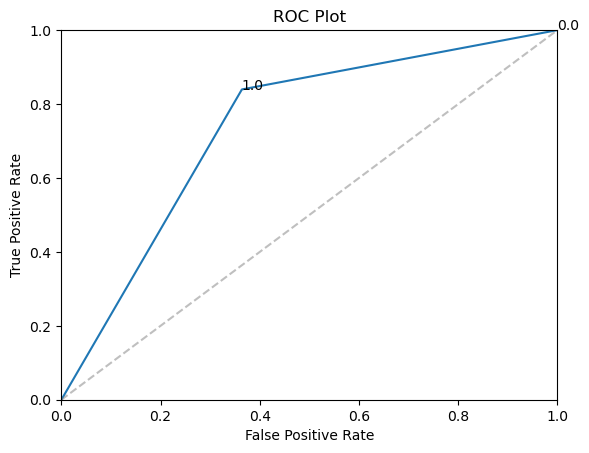

In [231]:
custom_roc_curve(y_test.tolist(), opt_probs.tolist())

While this is correct for the given model, k = 1 leads to very simple probability values, and thus a very simple and uninformative ROC plot. Increasing n_neighbors in the opt_model leads to a more interesting plot, and I spent some time trying to optimize alternative models with greater n_neighbors, and alternative threshold values other than 0.5. Still, *none* of these models could outperform my final optimized model with n=1 & p=1.

23) Compute the AUC score. [5 pts]

In [255]:
print("Optimal model AUC: ", custom_auc_score(y_test.tolist(), opt_probs.tolist()))
# k = 1 : AUC = 0.7378292687422809
# k = 5 : AUC = 0.7739105789968479
# k = 9 : AUC = 0.7622214234363767

Optimal model AUC:  0.7378292687422809


As discussed above, 2 <= k <= 10 results in a model with an AUC score greater than the AUC score of the k = 1 model. However, none of these models outperform the k = 1 model by any other metric, even when after tuning threshold values.
Ref: https://stackoverflow.com/questions/47104129/getting-a-low-roc-auc-score-but-a-high-accuracy

I chalk this up to the fact that AUC is not as black-and-white a measure as other performance metrics. For reference to the debate around how strictly to interpret AUC scores: http://sandeeptata.blogspot.com/2015/04/on-dangers-of-auc.html

24) Generate the precision-recall curve and determine the optimal threshold (visually). [5 pts]

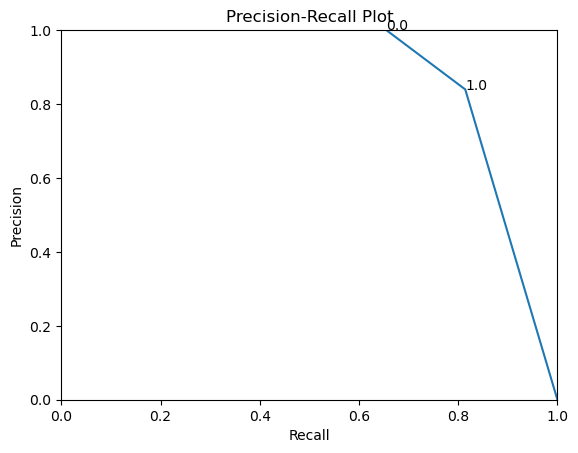

In [234]:
custom_precision_recall_curve(y_test, opt_probs)

As with ROC, my k = 1 leads to simple probability values, and thus a very simple and uninformative Precision-Recall curve.

25) Calculate and report the 95% confidence interval on the generalization error estimate. [5pts]
2 possible options (others as well):
1. Use the s fold accuracy scores (score for each fold) and take the standard deviation, then
subtracting/adding from the average, 1.96 (95% confidence interval) times the std dev
2. Use the following: Accuracy +/- 1.96 * sqrt( (accuracy * (1 - accuracy)) / n)

I wind up solving this both ways.

In [257]:
acc_score = custom_accuracy(y_test, opt_preds)
acc_conf_max = acc_score + 1.96 * sqrt((acc_score * (1-acc_score))/len(winequaltiy_white))
acc_conf_min = acc_score - 1.96 * sqrt((acc_score * (1-acc_score))/len(winequaltiy_white))
print("Accuracy 95% confidence interval: ", acc_conf_min, " - ", acc_conf_max)
f1_score = custom_F1_score(y_test, opt_preds)
f1_conf_max = f1_score + 1.96 * sqrt((f1_score * (1-f1_score))/len(winequaltiy_white))
f1_conf_min = f1_score - 1.96 * sqrt((f1_score * (1-f1_score))/len(winequaltiy_white))
print("\nF1 95% confidence interval: ", f1_conf_min, " - ", f1_conf_max)
mse = mean_squared_error(y_test, opt_preds)
mse_max = mse + 1.96 * sqrt((mse * (1-mse))/len(winequaltiy_white))
mse_min = mse - 1.96 * sqrt((mse * (1-mse))/len(winequaltiy_white))
print("\nMean Squared Error 95% confidence interval: ", mse_min, " - ", mse_max)

Accuracy 95% confidence interval:  0.7571963631159162  -  0.7808036368840838

F1 95% confidence interval:  0.8164069142638013  -  0.8375930857361986

Mean Squared Error 95% confidence interval:  0.21881554591127472  -  0.24240894388464362


I calculated the confidence interval for accuracy, and in addition calculated accuracies for F1 and MSE. 

To check my work, I also calculate the confidence interval the more intensive way--with a modification of my sFold function.

In [258]:
#This will be very similar to my earlier sFold function.
def sFold_conf_int(folds: int, data_sfold: np.ndarray, labels_sfold: np.ndarray, model: object, model_args: dict):
    """
     An S-fold cross-validation function.

    Parameters
    ----------
    folds : int,
        The number of folds.
    data_sfold : numpy array
        A numpy array with rows representing data samples and columns representing features.
    labels_sfold : numpy array
        An 1D array with labels corresponding to each row of training_features.
    model : model object
        Any object with the fit and predict methods
    model_args : dict
        dictionary of arguments to pass to the classification algorithm.
    """
    # Initialize lists for labels
    expected_labels = []
    predicted_labels = []
    _accs = []

    # Create KFold
    _kf = skl.model_selection.KFold(n_splits = folds)

    for _train_index, _test_index in _kf.split(data_sfold):
        # "Make a model using the model class"
        _model_instance = model(**model_args)

        # Split data into training and testing sets
        _X_train, _X_test = data_sfold[_train_index], data_sfold[_test_index]
        _y_train, _y_test = labels_sfold[_train_index], labels_sfold[_test_index]

        # "Fit the data to all other partitions (1 – folds)"
        # Fit the model on the training data
        _model_instance.fit(_X_train, _y_train)

        # Predict labels for the test data
        # "Make prediction on current partition"
        _y_pred = _model_instance.predict(_X_test)

        # "Store expected labels and predicted labels for current partition"
        expected_labels.extend(_y_test)
        predicted_labels.extend(_y_pred)

        # Calculate accuracy for this field
        acc = custom_accuracy(_y_test, _y_pred)
        _accs.append(acc)
        
    # returns standard deviation, and the upper and lower limits of the confidence interval for accuracy.
    return np.std(_accs), np.average(_accs) + np.std(_accs), np.average(_accs) - np.std(_accs)

In [246]:
sFold_conf_int(model = KNN_Classifier, model_args= {"weights":"uniform", "p":1, "n_neighbors":1}, data_sfold=X_train, labels_sfold=y_train, folds=5)

(0.010781465577554855, 0.778181465577555, 0.7566185344224452)

According to the above output, my confidence interval for accuracy is 0.75662 -  0.77818.

This is very close to the confidence interval for accuracy obtained by the simpler method above: 0.75720  -  0.78080.

26) Write a “Summary and Methods” section. [10 pts] No more than 2-5 sentences for each
question below:
i. Provide a summary of the project and what you completed in the assignment.
ii. Describe the dataset and features. What is the target? What are you calculating it from?
iii. Describe the differences in fit and predict between the regularized logistic regression vs
KNN_Classifier. In particular, discuss training time vs prediction time for large data.
Also discuss the hyperparameters of each and why they are used.

# SUMMARY AND METHODS
i. First, I constructed custom functions for a host of performance metrics & for calculating/plotting ROC, ROC AUC, and Precision-Recall curves. I implemented a custom KNN Classifier class and built KNN classifier and partition functions from the ground up. I investigated the relationship between the several variables in our wine quality dataset and selected several redundant or inconsequential variables which could be dropped. In doing so, I tried to serve the interests of both improving model efficiency by reducing dimensions (KNN being especially susceptible to the curse of dimensionality) and improving model performance (predictive power on test data) by removing colinear variables. I tested a variety of parameters, and eventually iterated over hyperparameters with kFold cross-validation to optimize our model. Lastly I assessed the performance of this optimal model via all the aforementioned metrics.
    
ii. We're working with a set of data about white wines. Things like their acidity, density, and alcohol content, plus a column denoting their subjective "quality" as given on a numeric scale (which we modify to a simple measure of "good" or "bad" by choosing a threshold value). Using this data, we're attempting to build a KNN model that can predict whether a wine is "good" or "bad" (our target) from data about the given features.

iii.    It's very apparent that the KNN_Classifier is *very* quick to train (simply assigning variables) and much slower to predict than the regularized logistic regressions. KNN hyperparameters were: "n_neighbors" (possibly the most consequential hyperparameter) which determines the number of neighbors to consider for each prediction point, "p" which determines the minkowski distance function p (p=1 generalizing to Manhattan distance and p=2 generalizing to Euclidean distance), and "weights" which determines how points are weighted-- distance weighting means decreasing the influence of a point on the classification of another point based on their distance from one another. Logistic Regression hyperparameters were: Penalty, the type of penalty function. L1 for lasso regression which (good for balancing bias and variance), L2 for ridge regression (can shrink some coeffs to zero, good for data with many features), and elasticnet, which combines the previous two at an adjustable ratio; and L1 ratio which is this adjustable ratio of L1 to L2 regularization.

27) Write a “Results” section. [15 pts] No more than 2-5 sentences for each question below
a) Describe the performance of the KNN model with respect to the different levels of k
and the different distance metrics. Include a table of performances, bolding the best.
b) Characterize the overall performance of your model.
c) Discuss which quality values (original rating) led to good performance of your model
and those that resulted in poor performance. Include a table of average error (e.g., F1
score) to support your claims.
d) Give any final conclusions.

# RESULTS
a) The KNN model performs best at k = 1 (one neighbor), p = 1 (Minkowski p = 1, Manhattan distance), and weighting = uniform (uniform weighting, k closest neighbors considered equally). Weighting doesn't seem to make a big difference, with the best-performing distance-weighted model achieving an F1 just slightly lower than the best-performing uniform-weighted model.  Likewise, Minkowski p does not appear to make a very big difference, with the best p = 2 model achieving an F1 only slightly lower than the best-performing uniform-weighted model. The effect of K on performance appears to be the most significant, and parabolic, with the worst performance of our tested models at k = 5, outperformed by models at both k = 1 and k = 9. Still, the k = 1 model performs better than either the k = 9 or k = 11 models. 

<u>Models table</u> This is taken directly from sfold_eval_results

| K     | Distance p | weights     | Average F1 |
|-------|------------|-------------|------------|
| 1     | 2          | uniform     | 0.8250     |
| 1     | 2          | distance    | 0.8248     |
| **1** | **1**      | **uniform** | **0.8264** |
| 1     | 1          | distance    | 0.8262     |
| 5     | 2          | uniform     | 0.8126     |
| 5     | 2          | distance    | 0.8104     |
| 5     | 1          | uniform     | 0.8098     |
| 5     | 1          | distance    | 0.8142     |
| 9     | 2          | uniform     | 0.8166     |
| 9     | 2          | distance    | 0.8124     |
| 9     | 1          | uniform     | 0.8128     |
| 9     | 1          | distance    | 0.8182     |
| 11    | 2          | uniform     | 0.8154     |
| 11    | 2          | distance    | 0.8152     |
| 11    | 1          | uniform     | 0.8142     |
| 11    | 1          | distance    | 0.8188     |

b) Overall, this model performs relatively well (subjective), with accuracy and F1 scores over 75% and MSE under 25%. I believe this performance is especially acceptable in on a subject like wine quality, where the stakes are relatively low (compared to, say, medical research). Additionally, the rates of false negatives and false positives are comparable, suggesting a threshold of 0.5 is reasonable. The only metric which gave me concern was AUC. Which is discussed above. 

c) From a manual analysis, I see that the quality values which lead to the worst performance are those closest to the partition point (5 and 6). I'm unsure what additionally this question might be asking for. I could check the points my opt model mis-classifies and determine what the original quality value was, and then analyze the distribution of those original quality values. However, that would require rewritting and re-running a lot of code, so I'm assuming that's not what you would want here. Otherwise, my table of average error (F1) across my tested models is above.

d) This exercise really illustrates the power of algorithmic models, given that even this from-scratch simple model can achieve relatively good performance on complex data--even compared to alternative official models from sklearn (like our LogRegs). It also illustrates the importance of choosing the right algorithm for the job, with KNN achieving superior performance, but inferior efficiency compared to the LogReg models we tested. 
I'm curious how effective this model might be on additional data, given that: 1) many measurements of the wine appear to be very specific, and I wonder what variation or error might be introduced by the use of different instruments at different times (eg. density of the same wine might vary depending on temperature; altitude; air pressure when/where a measurement is taken); 2) The subjectivity of a quality measurement may make it basically impossible to replicate, unless you are predicting quality for the same person/people who created the ratings on the original dataset. Post-submission I will be investigating how the SKLearn KNN algorithm is optimized over my own.

In [359]:
# incorrect_points = []
# for i in range(len(opt_preds)):
#     if opt_preds[i] != y_test[i]:
#         incorrect_points.append(i)
# 
# X_testdf = pd.DataFrame(X_test)
# y_testdf = pd.DataFrame(y_test)
# inc_rowsX = X_testdf.iloc[list(incorrect_points)]
# inc_rowsy = y_testdf.iloc[list(incorrect_points)]
# 
# print(np.mean(inc_rowsy))
# 
# inc_rowsX

0.4557522123893805


,0,1,2,3,4,5
2,5.5,0.240,0.060,102.0,0.99400,0.31
11,7.0,0.220,0.037,71.0,0.99020,0.38
16,7.4,0.180,0.064,103.0,0.99610,0.56
21,9.4,0.300,0.029,111.0,0.99580,0.42
28,7.1,0.280,0.028,91.0,0.99022,0.33
...,...,...,...,...,...,...
963,7.7,0.340,0.063,184.0,0.99690,0.63
973,6.2,0.345,0.056,187.0,0.99486,0.56
975,6.4,0.440,0.054,180.0,0.99520,0.57
976,7.7,0.300,0.048,119.0,0.99084,0.34
